## LAB1 A: Using Harris Corner Detection

Task in the PDF instructions and the files given doesn't seem to line up, I'll still try to complete this.

### Proceedure:

- Missing `Eg2_Harris_Corner_Detect_numpy_cv.ipynb`, will ignore this.
- Compare binary kernel to Gaussian kernel.
- Use Harris Corner Detection for 2 halves of an image.
- Using the 2 annotated halves, stitch it to 1 image.
- Missing `t1.png`, will ignroe this.
- Rotate an image by a random angle.
- Use HCD on rotated and original image, align and compare their position.

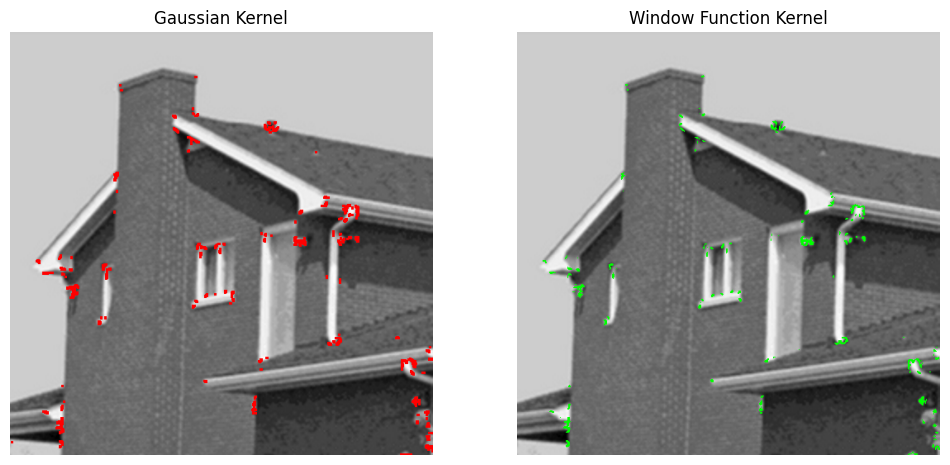

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('data/house.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

harris_gauss = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
harris_gauss = cv2.dilate(harris_gauss, None)
img_gauss = img.copy()
img_gauss[harris_gauss > 0.01 * harris_gauss.max()] = [0, 0, 255]

Ix = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
Iy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
Ix2 = Ix**2
Iy2 = Iy**2
Ixy = Ix*Iy
window = np.ones((3,3), dtype=np.float32)
Sxx = cv2.filter2D(Ix2, -1, window)
Syy = cv2.filter2D(Iy2, -1, window)
Sxy = cv2.filter2D(Ixy, -1, window)
det = Sxx*Syy - Sxy**2
trace = Sxx + Syy
R = det - 0.04*trace**2
img_window = img.copy()
img_window[R > 0.01*R.max()] = [0, 255, 0]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Gaussian Kernel")
plt.imshow(cv2.cvtColor(img_gauss, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Window Function Kernel")
plt.imshow(cv2.cvtColor(img_window, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

### Comparision Gaussian kernel vs Window kernel

- Gaussian kernel have more noise, bigger area of confidence.
- Using window function provides sharper corners, could give feeling of "thinner/weaker" detection

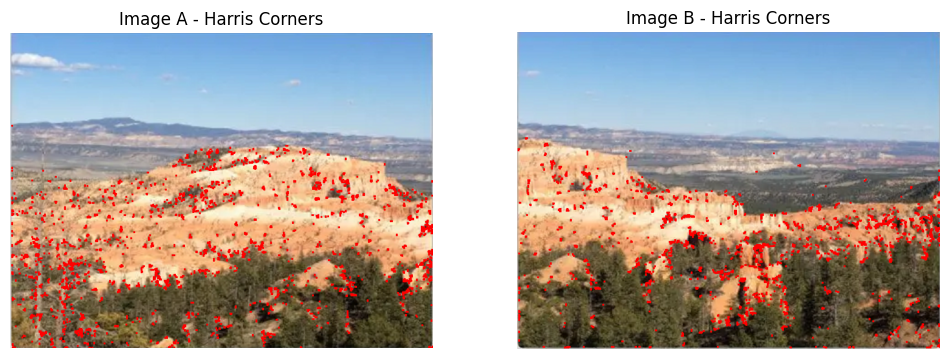

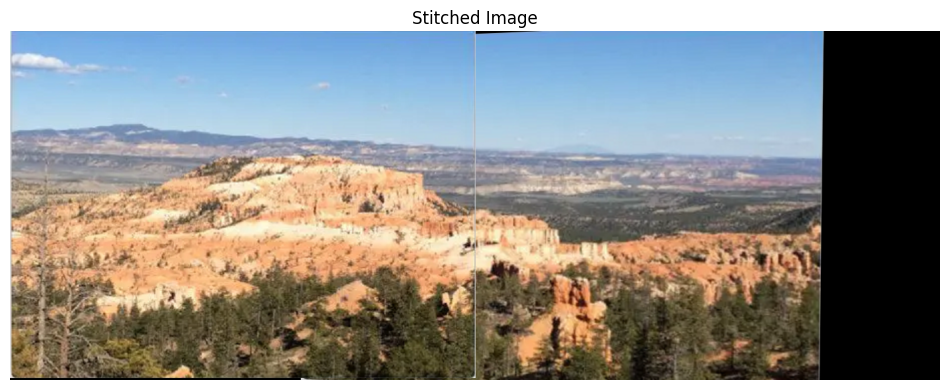

In [12]:
# Load images
imgA = cv2.imread('data/algn_test1_A.png')
imgB = cv2.imread('data/algn_test1_B.png')
grayA = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)

# Harris corner detection
def harris_corners(img, blockSize=2, ksize=3, k=0.04, thresh=0.03):
    gray = np.float32(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    dst = cv2.cornerHarris(gray, blockSize, ksize, k)
    dst = cv2.dilate(dst, None)
    img_c = img.copy()
    img_c[dst > thresh * dst.max()] = [0, 0, 255]
    corners = np.argwhere(dst > thresh * dst.max())
    corners = [tuple(pt[::-1]) for pt in corners]  # (x, y)
    return img_c, corners

# Detect corners with adjustable threshold
imgA_c, cornersA = harris_corners(imgA, thresh=0.02)
imgB_c, cornersB = harris_corners(imgB, thresh=0.02)

# Show corners side by side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Image A - Harris Corners")
plt.imshow(cv2.cvtColor(imgA_c, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Image B - Harris Corners")
plt.imshow(cv2.cvtColor(imgB_c, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# ORB descriptors on Harris corners
orb = cv2.ORB_create()
kpA = [cv2.KeyPoint(float(c[0]), float(c[1]), 3) for c in cornersA]
kpB = [cv2.KeyPoint(float(c[0]), float(c[1]), 3) for c in cornersB]
kpA, desA = orb.compute(grayA, kpA)
kpB, desB = orb.compute(grayB, kpB)

# Match descriptors using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(desA, desB)
matches = sorted(matches, key=lambda x: x.distance)

# Stitch images with A on the left, B on the right
if len(matches) >= 4:
    src_pts = np.float32([kpB[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kpA[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    hA, wA = imgA.shape[:2]
    hB, wB = imgB.shape[:2]

    # Warp B onto A’s plane
    stitched = cv2.warpPerspective(imgB, H, (wA + wB, max(hA, hB)))
    stitched[0:hA, 0:wA] = imgA
else:
    stitched = np.zeros((max(imgA.shape[0], imgB.shape[0]), wA + wB, 3), dtype=np.uint8)
    stitched[0:hA, 0:wA] = imgA
    stitched[0:hB, wA:wA+wB] = imgB

# Show stitched image
plt.figure(figsize=(12,6))
plt.title("Stitched Image")
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

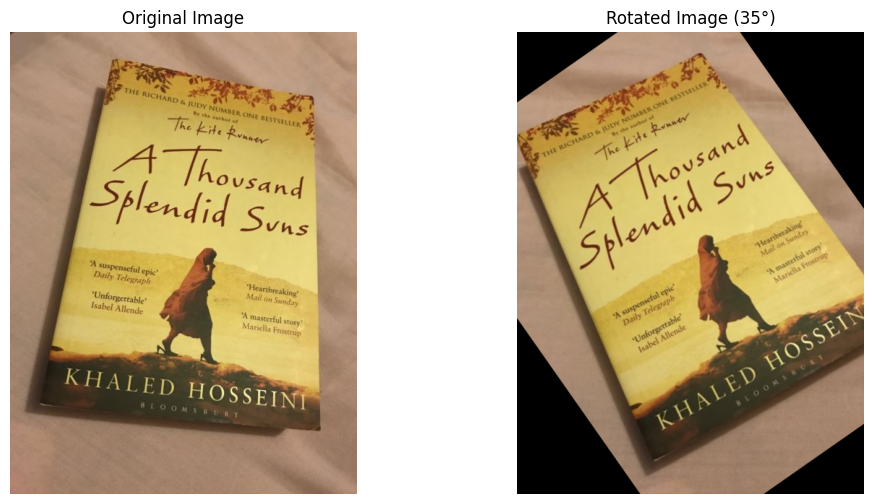

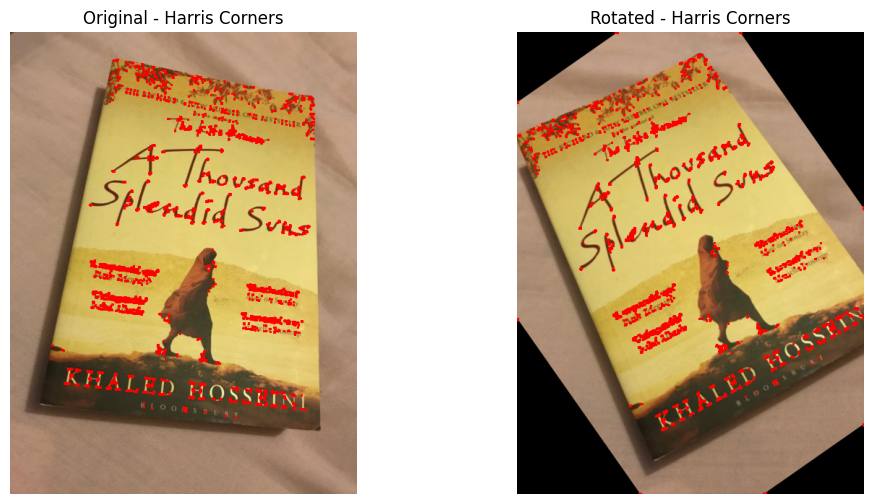

Estimated rotation (degrees): 34.69235166739743


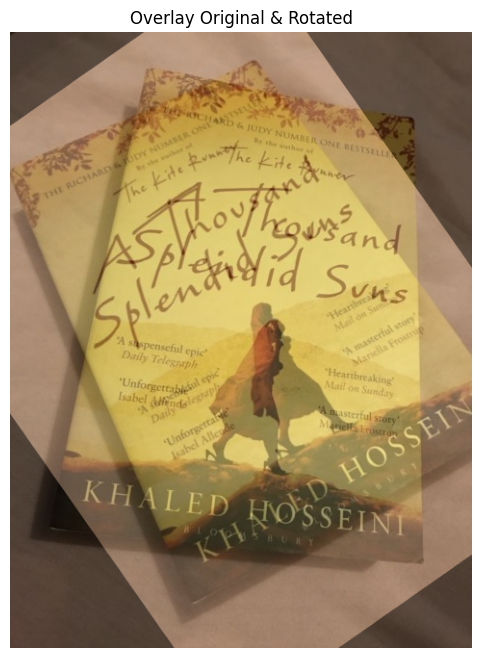

In [14]:
# Load image
img = cv2.imread('data/book1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Rotate image by a random degrees (around center, keep same size)
angle = 35
h, w = img.shape[:2]
center = (w//2, h//2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h))

# Display original and rotated side by side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title(f"Rotated Image ({angle}°)")
plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Harris corner detection function
def harris_corners(img, blockSize=2, ksize=3, k=0.04, thresh=0.01):
    gray = np.float32(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    dst = cv2.cornerHarris(gray, blockSize, ksize, k)
    dst = cv2.dilate(dst, None)
    img_c = img.copy()
    img_c[dst > thresh * dst.max()] = [0, 0, 255]
    corners = np.argwhere(dst > thresh * dst.max())
    corners = [tuple(pt[::-1]) for pt in corners]  # (x, y)
    return img_c, corners

# Detect corners on both images
img_c_orig, corners_orig = harris_corners(img)
img_c_rot, corners_rot = harris_corners(rotated)

# Display corners side by side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original - Harris Corners")
plt.imshow(cv2.cvtColor(img_c_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Rotated - Harris Corners")
plt.imshow(cv2.cvtColor(img_c_rot, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Try to estimate rotation using ORB descriptors at Harris corners
orb = cv2.ORB_create()
kp_orig = [cv2.KeyPoint(float(c[0]), float(c[1]), 3) for c in corners_orig]
kp_rot = [cv2.KeyPoint(float(c[0]), float(c[1]), 3) for c in corners_rot]
kp_orig, des_orig = orb.compute(gray, kp_orig)
kp_rot, des_rot = orb.compute(cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY), kp_rot)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_orig, des_rot)
matches = sorted(matches, key=lambda x: x.distance)

# Extract matched keypoints
src_pts = np.float32([kp_orig[m.queryIdx].pt for m in matches]).reshape(-1,2)
dst_pts = np.float32([kp_rot[m.trainIdx].pt for m in matches]).reshape(-1,2)

# Estimate affine transformation
if len(matches) >= 3:
    M_affine, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts)
    # Extract rotation angle from affine
    rotation_rad = np.arctan2(M_affine[0,1], M_affine[0,0])
    rotation_deg_est = np.degrees(rotation_rad)
else:
    rotation_deg_est = None

# Display estimated rotation
print("Estimated rotation (degrees):", rotation_deg_est)

# Overlay original and rotated images with some transparency
overlay = cv2.addWeighted(img, 0.5, rotated, 0.5, 0)
plt.figure(figsize=(8,8))
plt.title("Overlay Original & Rotated")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()